## 1. Importing Libraries & Load the file

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import cv2

## 3. Data Pre-processing (Balancing & Preparation)

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

# Load training dataset
train_dataset = image_dataset_from_directory(
    'train',                       # Path to your training folder
    image_size=(48, 48),           # Resize all images to 48x48
    color_mode='grayscale',        # Convert to grayscale
    batch_size=32,                 # Adjust as needed
    label_mode='categorical'       # One-hot encode labels automatically
)

# Load testing dataset
test_dataset = image_dataset_from_directory(
    'test',                        # Path to your testing folder
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Use data augmentation to balance and enrich your training data
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    'train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.


angry: 3995 images
disgust: 436 images
fear: 4097 images
happy: 7215 images
neutral: 4965 images
sad: 4830 images
surprise: 3171 images


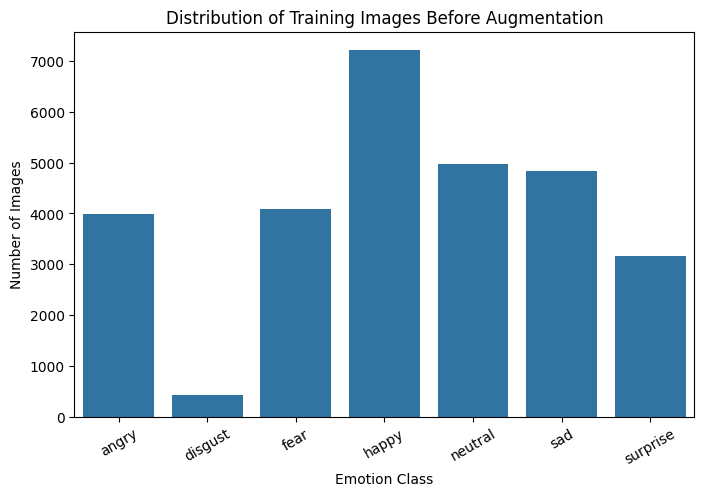

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your training directory
train_dir = 'train'

# Get class names (subfolder names)
class_names = sorted(os.listdir(train_dir))

# Count images in each class
counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names]

# Print counts
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count} images")

# Plot distribution
plt.figure(figsize=(8,5))
sns.barplot(x=class_names, y=counts)
plt.title("Distribution of Training Images Before Augmentation")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)
plt.show()


In [5]:
print("Class indices (mapping of folder names to label numbers):")
print(train_generator.class_indices)

Class indices (mapping of folder names to label numbers):
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
images, labels = next(train_generator)
print("Min pixel value:", images.min())
print("Max pixel value:", images.max())


Min pixel value: 0.0
Max pixel value: 1.0


In [7]:
images, labels = next(train_generator)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: (32, 48, 48, 1)
Label batch shape: (32, 7)


## 4. Model Building

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Build the CNN model
model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of model
model.summary()


c:\Users\dilip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,711 (9.43 MB)

 Trainable params: 2,471,815 (9.43 MB)

 Non-trainable params: 896 (3.50 KB)

## 5. Model Training

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create test data generator (only rescale, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_generator = test_datagen.flow_from_directory(
    'test',                     # path to your test folder
    target_size=(48, 48),       # resize images
    color_mode='grayscale',     # grayscale images
    batch_size=32,
    class_mode='categorical',   # 7-class one-hot labels
    shuffle=False               # keep order for evaluation
)


Found 7178 images belonging to 7 classes.


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt

# --- Dataset Paths ---
train_dir = r"C:\Users\dilip\OneDrive\Documents\Desktop\Facial-Expression-Detection-using-CNN-Real-Time-Recognition-with-Webcam-main\train"
test_dir  = r"C:\Users\dilip\OneDrive\Documents\Desktop\Facial-Expression-Detection-using-CNN-Real-Time-Recognition-with-Webcam-main\test"

# --- Load Datasets ---
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_data.class_names
print("Detected Emotion Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

# --- Enhanced Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# --- CNN Model ---
model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 1)),

    data_augmentation,

    layers.Rescaling(1./255),

    layers.Conv2D(64, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.35),

    layers.Conv2D(512, (3,3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')
])

# --- Compile Model ---
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_facial_expression_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# --- Train Model ---
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=60,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# --- Evaluate Model ---
test_loss, test_acc = model.evaluate(test_data)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# --- Plot Results ---
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout(); plt.show()

print("\n💾 Best model saved as best_facial_expression_model.keras")


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Detected Emotion Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,653,895 (13.94 MB)

 Trainable params: 3,651,463 (13.93 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/60
621/898 ━━━━━━━━━━━━━━━━━━━━ 2:06 455ms/step - accuracy: 0.1912 - loss: 2.7110

KeyboardInterrupt: 